## AdamW/SGDW benchmarking

This is to benchmark an implementation of https://arxiv.org/abs/1711.05101

In [1]:
PATH = "/home/as/datasets/fastai.cifar10/cifar10/"

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt
%matplotlib inline

### Common stuff for all experiments

In [4]:
def Get_SGD_Momentum(momentum=0.9):
    return lambda *args, **kwargs: optim.SGD(*args, momentum=momentum, **kwargs)

def Get_Adam():
    return lambda *args, **kwargs: optim.Adam(*args, **kwargs)

In [5]:
import pickle

def save_list(fname, l):
    with open(fname, "wb") as fp:
        pickle.dump(l, fp)
        
def read_list(fname):
    with open(fname, "rb") as fp:
        return pickle.load(fp)

### Section 1: Plot loss trends of various scenarios

### This is a common function which does the training. 

The only thing it asks for is the optimizer, and the initial LR for that optimizer. Hence we are comparing optimizers keeping all things same.

In [7]:
def experiment(optimizer, PATH, lr=1e-3, find_lr=False, use_wd_sched=False, wds=None, do_unfreeze=False):
    sz = 32
    bs = 120
    arch=resnet152
    cycle_len=2
    cycle_mult=2
    num_cycles = 4
    lr = lr
    
    if wds is None:
        weight_decay = 0.025 # As used in the paper https://arxiv.org/abs/1711.05101
    else:
        weight_decay = wds
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[1024, 512], opt_fn=optimizer)
    
    if find_lr:
        lrf=learn.lr_find()
        learn.sched.plot()
        return
    
    learn.fit(lr, 1, wds=weight_decay, use_wd_sched=use_wd_sched)
    print('Now with precompute as False')
    if do_unfreeze:
        learn.unfreeze()
        
    learn.precompute=False
    learn.fit(lr, num_cycles, wds=weight_decay, use_wd_sched=use_wd_sched, cycle_len=cycle_len, cycle_mult=cycle_mult)
    
    loss = learn.sched.losses
    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss)
    plt.show()
    learn.sched.plot_lr()
    
    return learn.sched.losses

### SGDR/SGDW

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 352/417 [00:08<00:01, 42.03it/s, loss=6.45]
CPU times: user 14 s, sys: 7.43 s, total: 21.5 s            
Wall time: 14.1 s


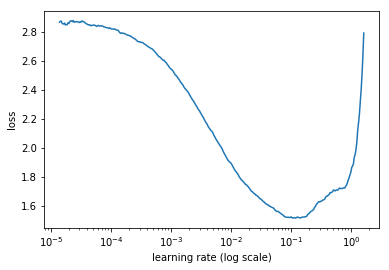

In [7]:
%%time
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, PATH=PATH, find_lr=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.10376  1.04945  0.6497 ]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.15792  1.01587  0.66141]                       
[ 1.       1.09858  0.97015  0.6754 ]                       
[ 2.       1.16542  1.04033  0.65704]                       
[ 3.       1.15431  1.05234  0.64712]                       
[ 4.       1.09005  0.98469  0.6746 ]                       
[ 5.       1.04615  0.95816  0.68482]                       
[ 6.       1.19502  1.08241  0.63889]                       
[ 7.       1.19519  1.08125  0.63889]                       
[ 8.       1.1898   1.04613  0.64762]                       
[ 9.       1.18039  1.05975  0.65238]                       
[ 10.        1.15745   1.01257   0.66587]                   
[ 11.        1.11558   0.9921    0.67004]                   
[ 12.        1.11037   0.96599   0.68085]                   
[ 13.        1.06509   0.96688   0.68175]                   
[ 14.        1.21265   1.09192   0.63829]                   
[ 15.        1.22316   1.09554   0.6372 ]                   
[ 16.        1.21343   1

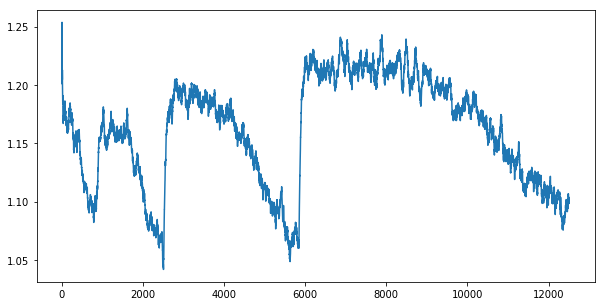

CPU times: user 24min 33s, sys: 6min 57s, total: 31min 30s
Wall time: 22min 18s


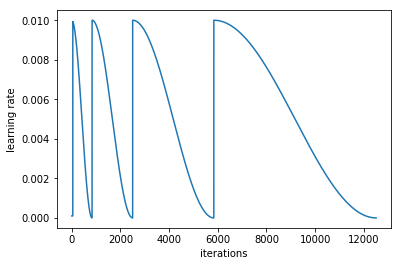

In [8]:
%%time
# Without weight decay
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, PATH=PATH, lr=1e-2)
save_list('sgdm_loss.txt', loss_sgdm)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.10877  0.99528  0.65228]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.11817  0.9575   0.66349]                       
[ 1.       1.06943  0.93098  0.67381]                       
[ 2.       1.08048  0.94051  0.67242]                       
[ 3.       1.04665  0.91659  0.67698]                       
[ 4.       1.0133   0.88877  0.69177]                        
[ 5.       0.99311  0.88643  0.69077]                        
[ 6.       1.04886  0.91844  0.67758]                       
[ 7.       1.02543  0.91373  0.67728]                       
[ 8.       1.0036   0.89098  0.68889]                        
[ 9.       0.96513  0.86736  0.69573]                        
[ 10.        0.96226   0.86149   0.70208]                    
[ 11.        0.90659   0.84314   0.70883]                    
[ 12.        0.89336   0.83507   0.70923]                    
[ 13.        0.88899   0.83253   0.71111]                    
[ 14.        1.01127   0.88314   0.68641]                    
[ 15.        0.9976    0.87663   0.69415]                    
[ 16.        0

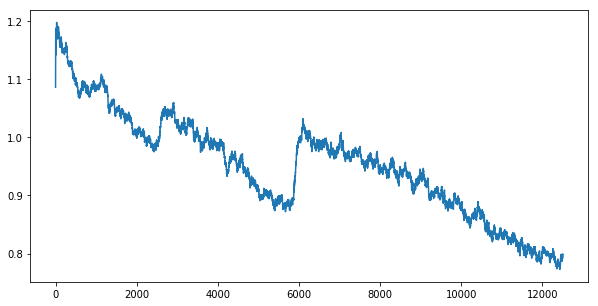

CPU times: user 24min 15s, sys: 6min 56s, total: 31min 11s
Wall time: 22min 3s


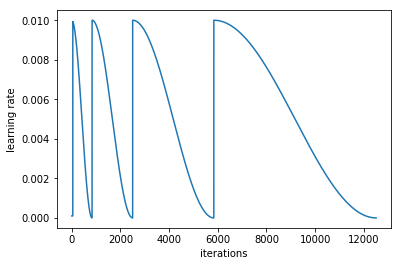

In [9]:
%%time
# With weight decay
sgdmw = Get_SGD_Momentum()
loss_sgdmw = experiment(sgdmw, PATH=PATH, lr=1e-2, use_wd_sched=True)
save_list('sgdmw_loss.txt', loss_sgdmw)

### Adam/AdamW

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▍  | 312/417 [00:08<00:02, 38.89it/s, loss=5.79]


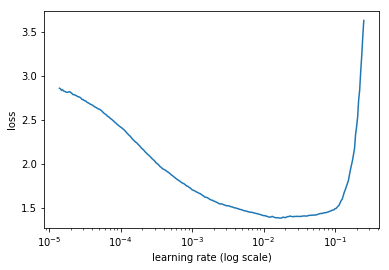

In [10]:
adam = Get_Adam()
loss_adam = experiment(adam, PATH, find_lr=True)

**Train**

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.17889  1.10539  0.6255 ]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.28137  1.12024  0.62897]                       
[ 1.       1.18919  1.03543  0.65685]                       
[ 2.       1.27788  1.14633  0.62113]                       
[ 3.       1.24533  1.09924  0.63512]                       
[ 4.       1.18939  1.03747  0.65933]                       
[ 5.       1.1485   1.00667  0.66895]                       
[ 6.       1.2722   1.14016  0.62004]                       
[ 7.       1.2661   1.13331  0.61349]                       
[ 8.       1.25628  1.12036  0.63443]                       
[ 9.       1.2345   1.09737  0.63264]                       
[ 10.        1.20076   1.05168   0.65337]                   
[ 11.        1.17597   1.03342   0.66399]                   
[ 12.        1.14168   1.00635   0.67183]                   
[ 13.        1.13233   0.99206   0.6752 ]                   
[ 14.        1.25707   1.15552   0.61845]                   
[ 15.        1.25385   1.10531   0.625  ]                   
[ 16.        1.27222   1

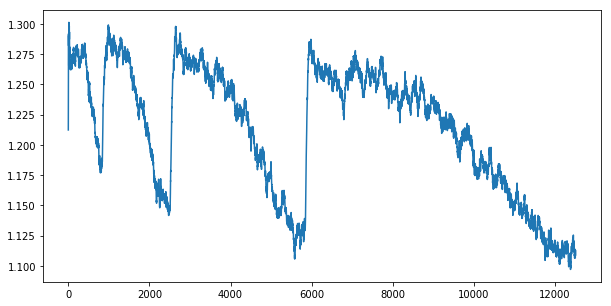

CPU times: user 23min 26s, sys: 6min 33s, total: 30min
Wall time: 20min 56s


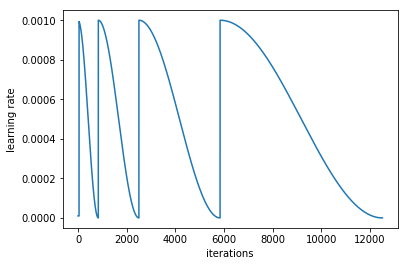

In [11]:
%%time
# Without weight decay
adam = Get_Adam()
loss_adam = experiment(adam, PATH, 1e-3)
save_list('adam_loss.txt', loss_adam)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.0357   0.96624  0.66111]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.08674  0.93315  0.67421]                       
[ 1.       1.00412  0.89507  0.68948]                        
[ 2.       1.04764  0.92108  0.67441]                       
[ 3.       1.00285  0.88393  0.69216]                        
[ 4.       0.9439   0.85717  0.70159]                        
[ 5.       0.89467  0.84547  0.70377]                        
[ 6.       1.01675  0.89594  0.68522]                        
[ 7.       0.98531  0.88032  0.69097]                        
[ 8.       0.96601  0.873    0.69058]                        
[ 9.       0.9384   0.85428  0.70109]                        
[ 10.        0.91351   0.83516   0.70605]                    
[ 11.        0.85846   0.82337   0.712  ]                    
[ 12.        0.84983   0.81272   0.71815]                    
[ 13.        0.84021   0.81208   0.71776]                    
[ 14.        0.96954   0.88298   0.6881 ]                    
[ 15.        0.97132   0.87667   0.69286]                    
[ 16.     

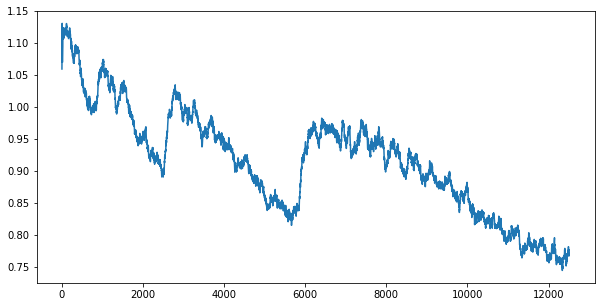

CPU times: user 23min 29s, sys: 6min 31s, total: 30min
Wall time: 20min 58s


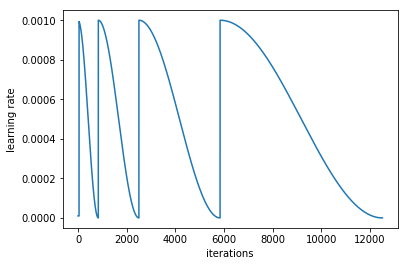

In [12]:
%%time
# With weight decay
adamw = Get_Adam()
loss_adamw = experiment(adamw, PATH, 1e-3, use_wd_sched=True)
save_list('adamw_loss.txt', loss_adamw)

### Differential Learning and Weight Decay

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.25515  1.03817  0.63145]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.13453  0.96852  0.65794]                       
[ 1.       1.05075  0.9269   0.6746 ]                       
[ 2.       1.0708   0.92946  0.67103]                       
[ 3.       1.02585  0.88549  0.6876 ]                       
[ 4.       0.96973  0.86592  0.69564]                        
[ 5.       0.90512  0.85552  0.70119]                        
[ 6.       1.02794  0.89723  0.6874 ]                        
[ 7.       0.99602  0.89368  0.687  ]                        
[ 8.       0.98489  0.87443  0.69544]                        
[ 9.       0.94576  0.85664  0.70556]                        
[ 10.        0.90807   0.84533   0.70724]                    
[ 11.        0.88612   0.82743   0.7123 ]                    
[ 12.        0.85337   0.82026   0.7129 ]                    
[ 13.        0.82903   0.81901   0.71379]                    
[ 14.        0.98625   0.87514   0.69087]                    
[ 15.        0.97893   0.88188   0.69286]                    
[ 16.       

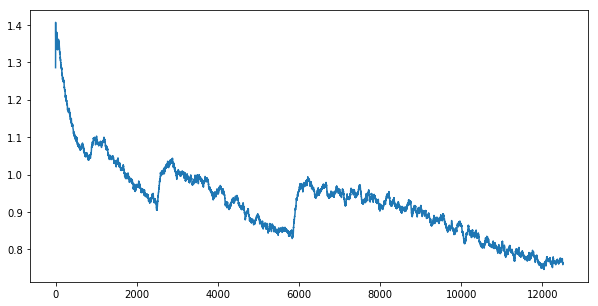

CPU times: user 23min 21s, sys: 6min 27s, total: 29min 49s
Wall time: 20min 46s


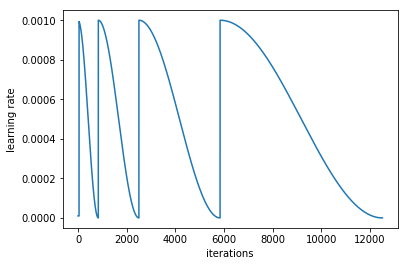

In [14]:
%%time
adamw_diff = Get_Adam()
lr = 1e-3
wd = 0.025
loss_adamw_diff = experiment(adamw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_sched=True)
save_list('loss_adamw_diff.txt', loss_adamw_diff)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.38687  1.14786  0.59861]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.18252  1.00508  0.64464]                       
[ 1.       1.14016  0.97778  0.65317]                       
[ 2.       1.12489  0.96591  0.6625 ]                       
[ 3.       1.05078  0.92282  0.67341]                       
[ 4.       1.03336  0.91198  0.67698]                       
[ 5.       1.02358  0.90594  0.67827]                        
[ 6.       1.06274  0.92763  0.67103]                       
[ 7.       1.03928  0.91548  0.68046]                       
[ 8.       1.00633  0.8965   0.68274]                        
[ 9.       0.98763  0.88099  0.69137]                        
[ 10.        0.98285   0.86165   0.69504]                    
[ 11.        0.92455   0.8483    0.7005 ]                    
[ 12.        0.9274    0.8435    0.70317]                    
[ 13.        0.92537   0.84272   0.70357]                    
[ 14.        1.01948   0.88406   0.69117]                    
[ 15.        1.00221   0.88764   0.68819]                    
[ 16.        0.

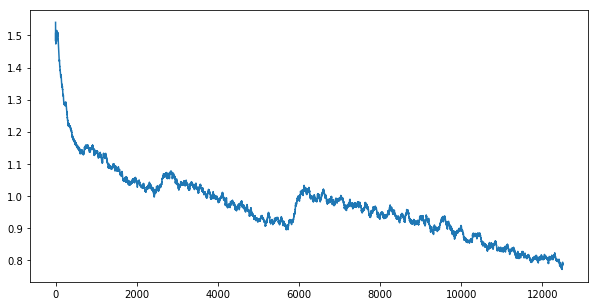

CPU times: user 23min 16s, sys: 6min 28s, total: 29min 44s
Wall time: 20min 38s


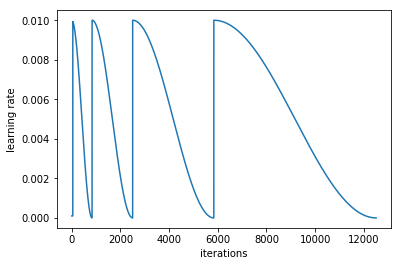

In [15]:
%%time
sgdw_diff = Get_SGD_Momentum(0.9)
lr = 1e-2
wd = 0.025
loss_sgdw_diff = experiment(sgdw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_sched=True)
save_list('loss_sgdw_diff.txt', loss_sgdw_diff)

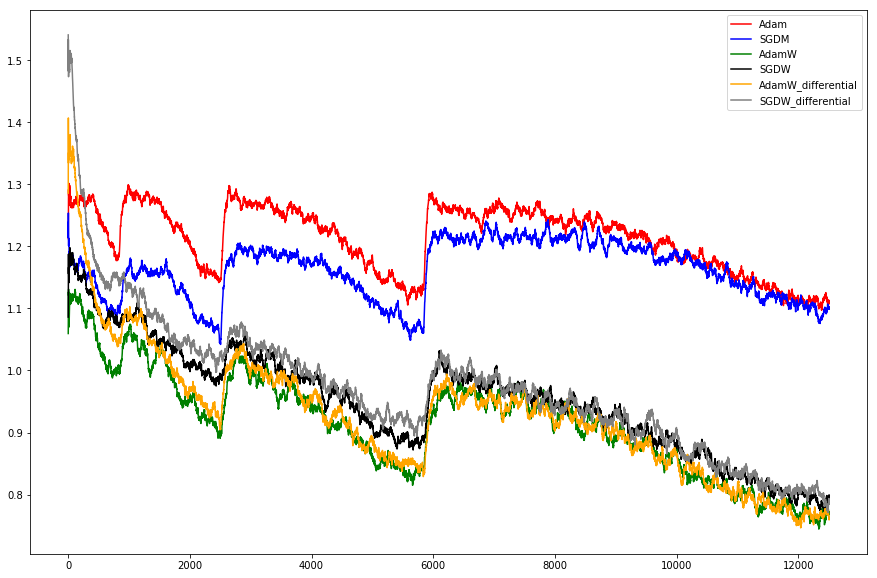

In [20]:
fig=plt.figure(figsize=(15, 10))
plt.plot(loss_adam, c='red', label='Adam')
plt.plot(loss_sgdm, c='blue', label='SGDM')
plt.plot(loss_adamw, c='green', label='AdamW')
plt.plot(loss_sgdmw, c='black', label='SGDW')
plt.plot(loss_adamw_diff, c='orange', label='AdamW_differential')
plt.plot(loss_sgdw_diff, c='gray', label='SGDW_differential')
plt.legend()
plt.show()

### Section 2: Check for regularization of overfitting

In [6]:
import time

In [7]:
def check_overfitting(optimizer, PATH, sz, bs, lr, wds, use_wd_sched=True):
    
    arch=resnet50
    cycle_len=12
    cycle_mult=2
    num_cycles = 1

    tfms = tfms_from_model(arch, sz) # aug_tfms=transforms_side_on, max_zoom=1.1
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    # Turning off Dropout, adding 3 extra FC layers to help in overfitting.
    learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[1024, 512], ps=[0, 0, 0], opt_fn=optimizer)

    print("==== Let's overfit the model. Expectation: training loss should reduce but validation loss should stagnate.")
    learn.unfreeze()
    learn.fit(lr, num_cycles, cycle_len=cycle_len, cycle_mult=cycle_mult)
    print("==== Let's introduce weight regularization. Expectation: training loss and validation loss should reduce. Accuracy should improve.")
    learn.fit(lr, num_cycles, wds=wds, use_wd_sched=use_wd_sched,  cycle_len=cycle_len, cycle_mult=cycle_mult)
    time.sleep(5)

**AdamW on Cats & Dogs**

In [6]:
%%time
PATH = "/home/as/datasets/fastai.dogscats/"
check_overfitting(Get_Adam(), PATH=PATH, sz=224, bs=96, lr=1e-3, wds=0.25, use_wd_sched=True)

==== Let's overfit the model. Expectation: training loss should reduce but validation loss should stagnate.


HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

[ 0.       0.12859  0.16524  0.93383]                         
[ 1.       0.08886  0.1369   0.94722]                         
[ 2.       0.06535  0.07461  0.96925]                         
[ 3.       0.03994  0.0733   0.97411]                         
[ 4.       0.02744  0.05134  0.98254]                         
[ 5.       0.00729  0.04754  0.98413]                          
[ 6.       0.00169  0.04154  0.98353]                          
[ 7.       0.00117  0.04216  0.98452]                           

==== Let's introduce weight regularization. Expectation: training loss and validation loss should reduce. Accuracy should improve.
########## Using Weight Decay ################


HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

[ 0.       0.21263  0.59829  0.61528]                          
[ 1.       0.31278  1.32242  0.50665]                        
[ 2.       0.32538  0.5101   0.74077]                        
[ 3.       0.29357  0.93977  0.59712]                        
[ 4.       0.25026  0.27308  0.88343]                        
[ 5.       0.20383  0.21023  0.92004]                        
[ 6.       0.14526  0.16384  0.93056]                        
[ 7.       0.11471  0.14075  0.93919]                        

CPU times: user 1h 6min 19s, sys: 12min 48s, total: 1h 19min 8s
Wall time: 43min 54s


**AdamW on Cifar10**

In [10]:
%%time
PATH = "/home/as/datasets/fastai.cifar10/cifar10/"
check_overfitting(Get_Adam(), PATH=PATH, sz=32, bs=320, lr=1e-3, wds=0.45, use_wd_sched=True)

==== Let's overfit the model. Expectation: training loss should reduce but validation loss should stagnate.


HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

[ 0.       1.17957  0.67314  0.76719]                       
[ 1.       0.51412  0.51901  0.82627]                        
[ 2.       0.31392  0.52229  0.83262]                        
[ 3.       0.20903  0.57125  0.82939]                        
[ 4.       0.12743  0.58579  0.84033]                        
[ 5.       0.07762  0.64476  0.84268]                         
[ 6.       0.03596  0.67429  0.84756]                         
[ 7.       0.01431  0.67829  0.85606]                         
[ 8.       0.00538  0.68094  0.86201]                          
[ 9.       0.00205  0.68386  0.86465]                          
[ 10.        0.00127   0.68932   0.86582]                      
[ 11.        0.00096   0.693     0.86514]                       

==== Let's introduce weight regularization. Expectation: training loss and validation loss should reduce. Accuracy should improve.
########## Using Weight Decay ################


HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

[ 0.       0.61522  2.04579  0.22295]                          
[ 1.       0.994    1.76384  0.4294 ]                        
[ 2.       1.15148  1.70932  0.42783]                       
[ 3.       1.17562  1.48411  0.4999 ]                       
[ 4.       1.11965  1.4601   0.50303]                       
[ 5.       1.08152  1.43367  0.50273]                       
[ 6.       1.01034  1.2748   0.5793 ]                       
[ 7.       0.93668  1.37345  0.55508]                        
[ 8.       0.83417  1.04571  0.66846]                        
[ 9.       0.73484  0.84381  0.73965]                        
[ 10.        0.63528   0.73409   0.7832 ]                    
[ 11.        0.5801    0.71925   0.78535]                    

CPU times: user 13min 57s, sys: 3min 59s, total: 17min 57s
Wall time: 12min 58s


**Adam on Cifar10**

In [11]:
%%time
PATH = "/home/as/datasets/fastai.cifar10/cifar10/"
check_overfitting(Get_Adam(), PATH=PATH, sz=32, bs=320, lr=1e-3, wds=0.45, use_wd_sched=False)

==== Let's overfit the model. Expectation: training loss should reduce but validation loss should stagnate.


HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

[ 0.       1.17344  0.73581  0.75928]                       
[ 1.       0.52352  0.50155  0.8292 ]                        
[ 2.       0.31334  0.56374  0.81914]                        
[ 3.       0.19731  0.57556  0.83262]                        
[ 4.       0.1422   0.60752  0.83408]                        
[ 5.       0.0851   0.60659  0.84873]                         
[ 6.       0.04055  0.62414  0.85566]                         
[ 7.       0.01519  0.64206  0.86348]                         
[ 8.       0.0059   0.65325  0.86562]                          
[ 9.       0.00316  0.66488  0.8668 ]                          
[ 10.        0.00131   0.66555   0.86699]                      
[ 11.        0.00112   0.66428   0.86816]                      

==== Let's introduce weight regularization. Expectation: training loss and validation loss should reduce. Accuracy should improve.


HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

[ 0.       0.53093  2.24064  0.19463]                          
[ 1.       1.33542  1.89998  0.36982]                       
[ 2.       1.42562  1.83148  0.36611]                       
[ 3.       1.40437  2.04909  0.28965]                       
[ 4.       1.39816  1.58744  0.50137]                       
[ 5.       1.43107  1.65807  0.45283]                       
[ 6.       1.45451  1.67957  0.47178]                       
[ 7.       1.4766   1.53491  0.59531]                       
[ 8.       1.49586  1.58658  0.60156]                       
[ 9.       1.50125  1.52028  0.65781]                       
[ 10.        1.49864   1.50836   0.66445]                  
[ 11.        1.49114   1.50533   0.66777]                   

CPU times: user 13min 47s, sys: 4min, total: 17min 48s
Wall time: 12min 50s
